# Homogeneous Gas Reactor (Ignition Zero D problem)

***Energy equation***
$$
\frac{dT}{dt}= -\frac{1}{\rho c_p}\sum_{k=1}^{N_{spec}}\dot{\omega_{k}} W_k h_k = S_T
$$
***Species equation***
$$
\frac{dY_k}{dt}=\frac{1}{\rho}\dot{\omega_{k}}W_k=S_{Y_k},\,\,\,k=1\ldots N_{spec}
$$

## Environment Setup

In [1]:
TChem_install_directory ='where/TChem/is/installed'

In [2]:
import sys
sys.path.append(TChem_install_directory+'/lib')
import pytchem
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats

In [3]:
sys.path.append(TChem_install_directory+'/example/runs/scripts/')
import pmixSample
import helper

## Pre-simulation
* Set variables; temperature and stoichiometric ratio (fuel/air).
* Convert from stoichiometric ratio to mass fraction of H2 and O2.
* Create samples spaning over the variable ranges.

In [4]:
# Pressure, Temperature, phi(stoichiometric ratio)
one_atm = 101325 # [Pa]
Temp = 900   #  temperature [K]
Pressure = 1*one_atm; # [Pa]
phi = 1.0; # Maximum equivalence ratio [-]


In [5]:
N=100
Nvar = 6
sample = np.zeros([N,Nvar])

In [6]:
fuel ="H2"
header_fuel = "T P " + fuel + " O2"
Nvar = 4
Yp_fuel, Yr_o2 = pmixSample.getMassFractionH2(phi)

In [7]:
sample = np.zeros([N,Nvar])
sample[:,0] = Temp
sample[:,1] = Pressure
sample[:,2] = Yp_fuel
sample[:,3] = Yr_o2

## TChem Simulation

### Initialize TChem Driver Object

* Initialization of Kokkos.
* Create a TChem driver object. 

In [8]:
pytchem.initialize()

In [9]:
tchem = pytchem.TChemDriver()

* Get help from TChem driver object.

In [10]:
help(tchem)

Help on TChemDriver in module pytchem object:

class TChemDriver(pybind11_builtins.pybind11_object)
 |  A class to manage data movement between numpy to kokkos views in TChem::Driver object
 |  
 |  Method resolution order:
 |      TChemDriver
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: pytchem.TChemDriver) -> None
 |  
 |  cloneGasKineticModel(...)
 |      cloneGasKineticModel(self: pytchem.TChemDriver) -> None
 |      
 |      Internally create clones of the kinetic model
 |  
 |  computeGasEnthapyMass(...)
 |      computeGasEnthapyMass(self: pytchem.TChemDriver) -> None
 |      
 |      Compute enthalpy mass and mixture enthalpy
 |  
 |  computeGasNetProductionRatePerMass(...)
 |      computeGasNetProductionRatePerMass(self: pytchem.TChemDriver) -> None
 |      
 |      Compute net production rate
 |  
 |  computeGasReactionRateConstants(...)
 |      computeGasReactionRateConstants(sel

### Create Kinetic Model 

* Inputs are the reactions mechanism files; in this case, we use the GRI3.0 gas reaction mechanism

In [11]:
inputs_directory = TChem_install_directory + '/example/data/H2/'
tchem.createGasKineticModel(inputs_directory+'chem.inp',inputs_directory+'therm.dat')

In [12]:
tchem.setNumberOfSamples(N)

 ### Model Variation
* Set list of reaction to be modified .

In [13]:
Nparameter= 19
reaction_index = np.arange(Nparameter)
print(reaction_index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


* Set a 3d array, factors, of dimension: Number of samples (N), number of reaction to be modified (Nparameter), 3 that corresponds to three Arrenius parameters: pre exponetial (0), temperature coeficient(1), activation energy(2). 

In [14]:
μ=0 
σ=.25
A_modifier = np.random.lognormal(μ, σ, size=(N, Nparameter))
factors = np.empty([N,Nparameter,3])
ones = np.ones([N,Nparameter])
factors[:,:,0] = A_modifier # //pre exponetial 
factors[:,:,1] = ones # temperature coef 
factors[:,:,2] = ones # activation energy 

* Create a list of const objects of the kinetic model with the modified parameters. 

In [15]:
tchem.createGasKineticModelConstDataWithArreniusForwardParameters(reaction_index,factors)

* Verify the changes comparing reference values vs modified variables for a specific sample (isample).

In [16]:
ver_reaction_index = np.zeros(3,dtype=int)
ver_reaction_index[0] = 1
ver_reaction_index[1] = 3
ver_reaction_index[2] = 6
pre_exponetial_index = 0
isample=84

A_original = tchem.getGasArrheniusForwardParameter(ver_reaction_index, pre_exponetial_index); 
A_modified = tchem.getGasArrheniusForwardParameter(isample, ver_reaction_index, pre_exponetial_index);

In [17]:
print('Pre exponential Original:', A_original)
print('Pre exponential Modified:', A_modified)
print('Factor                  :', A_modified/A_original)

Pre exponential Original: [5.080e+04 1.230e+04 4.714e+18]
Pre exponential Modified: [6.34132474e+04 1.51141650e+04 5.65527868e+18]
Factor                  : [1.24829227 1.2287939  1.19967728]


In [18]:
for isample in [3, 20, 40, 53, 83]:
    A_original = tchem.getGasArrheniusForwardParameter(reaction_index, pre_exponetial_index); 
    A_modified = tchem.getGasArrheniusForwardParameter(isample, reaction_index, pre_exponetial_index);
    factor = A_modified/A_original
    for i, ifac in enumerate(factor):
        error = (ifac - A_modifier[isample,i])/ A_modifier[isample,i]
        if abs(error) > 1e-15:
            print('error in ',error,' in sample No',isample,' factor No', i)
    

### Set State Vector

* Get index for variables. 
* Pass a numpy array to the TChem object to set the state vector. 

In [19]:
Variables = ['T','P','H2','O2']
indx=[]
for var in Variables:
    indx += [tchem.getStateVariableIndex(var)]

state = np.zeros([N, tchem.getLengthOfStateVector()])
for sp in range(N):
    state[sp,indx] = sample[sp,:]

In [20]:

tchem.createStateVector()
tchem.setStateVector(state)

### Set Time Integrator and Its Parameters 
* Kokkos team policy is constructed for parallel execution
* Workspace per team is also allocated with the teampolicy

In [21]:
tend = 2
tchem.setTimeAdvanceHomogeneousGasReactor(tbeg=0, 
                     tend=tend, 
                     dtmin=1e-10,
                     dtmax=1e-3, 
                     atol_time=1e-12,
                     rtol_time=1e-6,
                     max_num_newton_iterations=20,
                     atol_newton=1e-18,
                     rtol_newton=1e-8,
                     num_time_iterations_per_interval=20,
                     jacobian_interval=1)

* Advance simulations: for each iteration, get state vector. 

In [22]:
solution = []
time_simulation = []

tavg = 0
t0 = time.time()
icount = 0
while (tavg < tend*0.999):
    tavg = tchem.computeTimeAdvanceHomogeneousGasReactor()
    solution += [tchem.getStateVector()]
    time_simulation += [tchem.getTimeStep()]
    icount +=1
    if (icount%50 == 0):
        print(f"count {icount:3d} simulation time {tavg:10.3e} s, total time {tend:10.3e} s")

t1 = time.time()

print(f"Wall time is {(t1 - t0)/60:0.4f} mins for time integration")

solution = np.array(solution)
time_simulation = np.array(time_simulation) 

count  50 simulation time  4.450e-01 s, total time  2.000e+00 s
count 100 simulation time  1.445e+00 s, total time  2.000e+00 s
Wall time is 0.3973 mins for time integration


## Post-processing
* Get variable index for plotting. 
* Compute the ignition delay time with data produced by the simulation.
* Plot time profiles for important variables and for the ignition delay time.

In [23]:
T_indx   = tchem.getStateVariableIndex('T')
H2_indx = tchem.getStateVariableIndex('H2')
O2_indx  = tchem.getStateVariableIndex('O2')
OH_indx  = tchem.getStateVariableIndex('OH')

In [24]:
T_threshold=1500
def computeIgnitionDelayTime(T_threshold=1500):
    ntimes, nsamples, nVars = np.shape(solution)
    ignDelayTime = []
    for isample in range(nsamples):
        Indx = np.where(solution[:,isample,T_indx] >= T_threshold )
        ignDelayTime += [time_simulation[Indx[0][0],isample] ] 
    return np.array(ignDelayTime)

In [25]:
IgnTime = computeIgnitionDelayTime()
np.savetxt('QoI_H2.txt',IgnTime)

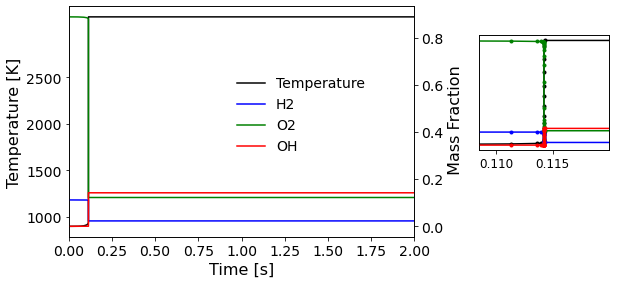

In [26]:
info={}
info['label1'] = {'label':'Temperature','units':' [K]'}
info['label2'] = {'label': 'H2','units':' Mass Fraction'}
info['label3'] = {'label': 'O2','units':'  Mass Fraction'}
info['label4'] = {'label': 'OH','units':'  Mass Fraction'}
info['loc_x'] = 0.45
info['loc_y'] = 0.75
info['xlim'] = [0,1]

info['inset_x1'] = 0.55 + 0.5 
info['inset_y1'] = 0.4
info['inset_x2'] = 0.3 
info['inset_y2'] = 0.4

spNumber = 53
info['xlim2'] = [IgnTime[spNumber]*0.95,IgnTime[spNumber]*1.05]
info['xlim'] = [0,time_simulation[-1,spNumber]]

x  = time_simulation[:,spNumber]
y1 = solution[:,spNumber, T_indx]
y2 = solution[:,spNumber, H2_indx]
y3 = solution[:,spNumber, O2_indx]
y4 = solution[:,spNumber, OH_indx]
helper.makefigure(x, y1, y2, y3, y4, info, fs_label=16, fs_tick=14)
plt.savefig('H2_TimeProfile.pdf', bbox_inches = 'tight')

Finalize Kokkos. This deletes the TChem object and the data stored as Kokkos views

In [27]:
gkde = stats.gaussian_kde(dataset=IgnTime)
x = np.linspace(start=np.min(IgnTime),
                stop=np.max(IgnTime), num=N)

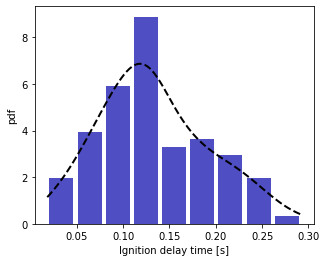

In [28]:
plt.figure(figsize=[5,4])
n, bins, patches = plt.hist(x=IgnTime, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85,density=True)
plt.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2)
plt.xlabel('Ignition delay time [s]')
plt.ylabel('pdf')
# plt.ylim([0,4])
plt.savefig('H2_IgniDelayPdf.pdf', bbox_inches = 'tight')

In [29]:
del(tchem)

In [30]:
pytchem.finalize()